#📘 Machine Learning 2025/2026  
#Laboratorio 10 — Multilayer Perceptron e Backpropagation (NumPy from Scratch + PyTorch)  

###Docenti: Danilo Croce, Giorgio Gambosi

In questo laboratorio costruiremo **da zero** una piccola rete neurale per **classificazione binaria** su un dataset 2D **non linearmente separabile** (es. *two moons* / cerchi).  
L’obiettivo non è “usare una libreria”, ma capire **cosa succede davvero** durante **forward + loss + backprop + update**.

---

## Cosa imparerai (obiettivi)

Alla fine del notebook sarai in grado di:

1. Generare e visualizzare un dataset 2D non linearmente separabile.
2. Addestrare un **classificatore lineare** (logistic regression) e capire *perché fallisce* su dati non separabili linearmente.
3. Implementare una **MLP** piccola (pochi layer) in NumPy:
   - forward pass
   - binary cross-entropy loss
   - backpropagation (gradienti di $W$ e $b$)
   - gradient descent
4. Visualizzare:
   - andamento della loss (e accuracy)
   - **decision boundary** in 2D
5. Rifare la **stessa rete in PyTorch** e confrontare con la versione “manuale”.

---

## Struttura del laboratorio

1. **Dataset toy**: generazione + plot
2. **Baseline lineare**: logistic regression (1 layer) + boundary
3. **MLP from scratch**: 2 → H → 1
   - forward
   - loss
   - backward (backprop)
   - training loop
4. **Confronto**: boundary lineare vs boundary non lineare
5. **PyTorch**: stessa architettura con `nn.Module` + `autograd`

---

## Notazione (coerente con le slide)

Useremo questa notazione per un layer generico $r$:

- **Pre-attivazione**:
$$
a^{(r)} = z^{(r-1)} W^{(r)} + b^{(r)}
$$
- **Output del layer**:
$$
z^{(r)} = h(a^{(r)})
$$

Nel caso della nostra MLP binaria:

- Hidden layer:
$$
a^{(1)} = XW^{(1)} + b^{(1)}, \quad z^{(1)} = h(a^{(1)})
$$
- Output layer:
$$
a^{(2)} = z^{(1)}W^{(2)} + b^{(2)}, \quad \hat{y} = z^{(2)} = \sigma(a^{(2)})
$$

---

## Metriche e loss

Per classificazione binaria useremo:

- Predizione $\hat{y} \in (0,1)$
- Target $t \in \{0,1\}$
- **Binary Cross-Entropy** (per singolo esempio):
$$
E = -\Big(t\log(\hat{y}) + (1-t)\log(1-\hat{y})\Big)
$$

> Nota: più avanti, in PyTorch useremo una forma numericamente stabile (`BCEWithLogitsLoss`), ma qui partiamo dalla versione “didattica”.

---

## Checklist prima di iniziare

- Hai chiaro che cos’è un **dataset non linearmente separabile**?
- Sai distinguere tra:
  - $a$: somma pesata (lineare)
  - $z$: output dopo l’attivazione (non lineare)
- Sai cosa significa aggiornare i pesi con gradient descent?
$$
W \leftarrow W - \eta \nabla_W E
$$

Se qualcosa non è chiaro, nessun problema: lo vedremo “in diretta” mentre lo implementiamo.

---

✅ **Prossimo blocco**: generiamo un dataset 2D (two moons o cerchi), facciamo lo scatter plot e creiamo train/test split.

## 1️⃣ Dataset toy: dati non linearmente separabili

Iniziamo con un **dataset artificiale 2D** pensato apposta per essere:
- facile da visualizzare
- **non separabile linearmente**

Questo ci permetterà di capire *perché* un classificatore lineare fallisce e *cosa* aggiunge una rete con più layer.

Useremo un dataset classico: **two moons** (due semicerchi intrecciati).

---

### Perché two moons?

- È bidimensionale → possiamo disegnare la **decision boundary**
- Non esiste **una retta** che separa perfettamente le due classi
- È lo stesso tipo di esempio usato spesso per spiegare MLP e kernel methods

Intuitivamente, i punti delle due classi sono “incastrati”.

---

### Struttura dei dati

Il dataset sarà composto da:
- input $X \in \mathbb{R}^{N \times 2}$
- label $y \in \{0,1\}^N$

Ogni punto ha:
$$
x = (x_1, x_2), \quad y \in \{0,1\}
$$

---

### Cosa faremo nel codice (nel prossimo blocco)

1. Generare il dataset
2. Separare **training** e **test set**
3. Visualizzare i punti con uno scatter plot
4. (Opzionale) normalizzare i dati

---

### Domande guida (da tenere a mente)

Prima ancora di addestrare un modello, chiediti:

- Riusciresti a separare questi punti con una retta?
- Che tipo di trasformazione servirebbe per “stirarli” e renderli separabili?

> Queste domande torneranno quando introdurremo il layer nascosto.

---

👉 **Nel prossimo blocco**: codice per generare il dataset, scatter plot e train/test split.

## 2️⃣ Generazione del dataset (two moons)

Ora passiamo al codice.

Genereremo un dataset **two moons** usando `scikit-learn`, poi:
- divideremo i dati in training e test set
- visualizzeremo i punti in 2D

L’obiettivo non è il dataset in sé, ma **capire visivamente** perché un modello lineare non basta.

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Fissiamo un seed per rendere i risultati riproducibili
np.random.seed(42)

# Generazione del dataset
X, y = make_moons(
    n_samples=400,
    noise=0.08,
    random_state=42
)


# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

mu = X_train.mean(axis=0, keepdims=True)
sigma = X_train.std(axis=0, keepdims=True) + 1e-8
X_train = (X_train - mu) / sigma
X_test  = (X_test  - mu) / sigma

X_train.shape, y_train.shape

((280, 2), (280,))

### Visualizzazione del dataset

Disegniamo ora i punti del training set.
Useremo colori diversi per le due classi.

Osserva attentamente la forma dei dati prima di andare avanti.

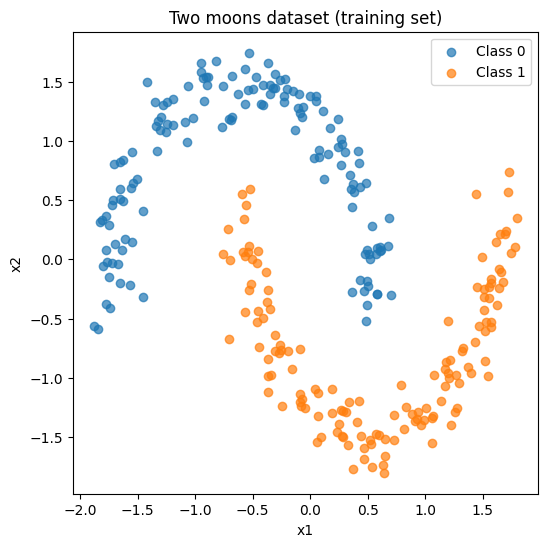

In [ ]:
plt.figure(figsize=(6, 6))

plt.scatter(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    label="Class 0",
    alpha=0.7
)

plt.scatter(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    label="Class 1",
    alpha=0.7
)

plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Two moons dataset (training set)")
plt.show()

### Osservazione importante

- Esiste una **retta** che separa perfettamente le due classi?
- Cosa succede se proviamo a usare una logistic regression?

Nel prossimo blocco implementeremo **un classificatore lineare** e vedremo cosa riesce (e cosa non riesce) a fare.

👉 **Prossimo step**: logistic regression *from scratch* (1 layer).

## 3️⃣ Baseline: classificatore lineare (logistic regression)

Iniziamo con il modello più semplice possibile per la classificazione binaria:

- **un solo layer**
- trasformazione lineare
- funzione sigmoide
- binary cross-entropy loss

Questo modello ha la forma:

$$
a = XW + b
$$

$$
\hat{y} = \sigma(a)
$$

---

### Perché partiamo da qui?

Perché:
- è un caso particolare di rete neurale (senza hidden layer)
- è facile da implementare
- ci permetterà di **vedere chiaramente il limite della separazione lineare**

Se questo modello fallisce, **non è colpa dell’ottimizzazione**, ma della **capacità del modello**.

---

In [ ]:
# Funzioni di base: sigmoide e loss

def sigmoid(a):
    return 1 / (1 + np.exp(-a))


def binary_cross_entropy(y_pred, y_true, eps=1e-8):
    """
    BCE media sul batch.

    y_pred è una colonna di N probabilità (una per riga), quindi ha forma (N, 1).
    y_true spesso è un vettore di N etichette (0/1), quindi ha forma (N,).

    Li trasformiamo entrambi in "colonne" (N,1) così:
    - ogni probabilità si confronta con la sua etichetta corrispondente riga per riga
    - evitiamo che Python combini i valori nel modo sbagliato

    In pratica: serve solo a dire “una label per ogni predizione”, allineate riga per riga.
    """
    y_pred = np.clip(y_pred, eps, 1 - eps)
    y_true = y_true.reshape(-1, 1)

    return -np.mean(
        y_true * np.log(y_pred) +
        (1 - y_true) * np.log(1 - y_pred)
    )

### Inizializzazione dei parametri

Il nostro modello ha:
- una matrice dei pesi $$W \in \mathbb{R}^{2 \times 1}$$
- un bias scalare $$b$$

Li inizializziamo con piccoli valori casuali.

### Forward pass

Dato un batch di input $X$, calcoliamo:

$$
a = XW + b
$$

$$
\hat{y} = \sigma(a)
$$

In [ ]:
def forward_linear(X, W, b):
    a = X @ W + b
    y_pred = sigmoid(a)
    return a, y_pred

### Backward pass (gradienti)

Ora calcoliamo **a mano** i gradienti.

Ricordiamo che per logistic regression + BCE vale:

$$
\frac{\partial E}{\partial a} = \hat{y} - y
$$

Da cui:

$$
\frac{\partial E}{\partial W} = \frac{1}{N} X^T (\hat{y} - y)
$$

$$
\frac{\partial E}{\partial b} = \frac{1}{N} \sum (\hat{y} - y)
$$

In [ ]:
def backward_linear(X, y_true, y_pred):
    N = X.shape[0]
    error = y_pred - y_true.reshape(-1, 1)

    dW = (1 / N) * X.T @ error
    db = (1 / N) * np.sum(error)

    return dW, db

### Training loop

Addestriamo ora il modello con **gradient descent batch**.

Teniamo traccia della loss per capire se il modello sta imparando.

In [ ]:
# Dimensioni
n_features = X_train.shape[1]

# Inizializzazione
W = 0.01 * np.random.randn(n_features, 1)
b = 0.0

# Iperparametri
learning_rate = 0.1
n_epochs = 2000

loss_history_lin = []

for epoch in range(n_epochs):
    # Forward
    a, y_pred = forward_linear(X_train, W, b)

    # Loss
    loss = binary_cross_entropy(y_pred, y_train)
    loss_history_lin.append(loss)

    # Backward
    dW, db = backward_linear(X_train, y_train, y_pred)

    # Update
    W -= learning_rate * dW
    b -= learning_rate * db

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss:.4f}")

Epoch    0 | Loss: 0.6912
Epoch  200 | Loss: 0.2607
Epoch  400 | Loss: 0.2487
Epoch  600 | Loss: 0.2457
Epoch  800 | Loss: 0.2448
Epoch 1000 | Loss: 0.2444
Epoch 1200 | Loss: 0.2442
Epoch 1400 | Loss: 0.2442
Epoch 1600 | Loss: 0.2441
Epoch 1800 | Loss: 0.2441


### Andamento della loss

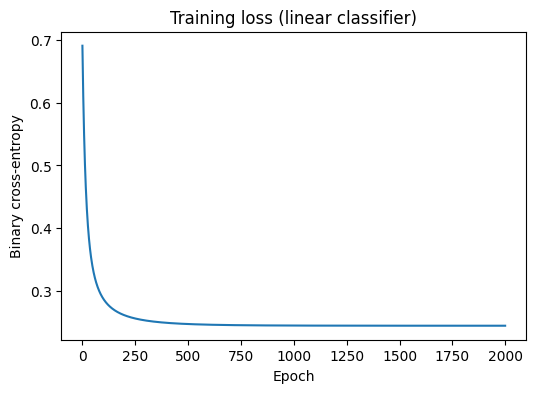

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(loss_history_lin)
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.title("Training loss (linear classifier)")
plt.show()

### Valutazione sul test set

In [ ]:
_, y_test_pred = forward_linear(X_test, W, b)
y_test_labels = (y_test_pred >= 0.5).astype(int)

accuracy = np.mean(y_test_labels.flatten() == y_test)

print(f"Test accuracy: {accuracy:.3f}")

Test accuracy: 0.842


### Decision boundary del classificatore lineare

Disegniamo ora la **frontiera di decisione**.

Se il modello fosse adeguato, la frontiera seguirebbe la forma delle lune.
Vediamo cosa succede davvero.

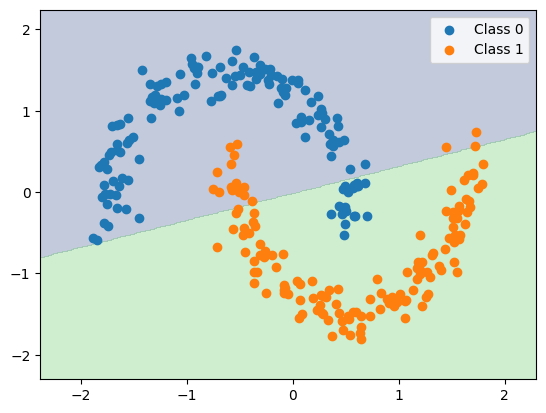

In [ ]:
def plot_decision_boundary(model_forward, W, b, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    _, preds = model_forward(grid, W, b)
    preds = preds.reshape(xx.shape)

    plt.contourf(xx, yy, preds >= 0.5, alpha=0.3)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class 0")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class 1")
    plt.legend()
    plt.show()

plot_decision_boundary(forward_linear, W, b, X_train, y_train)

### Conclusione (importante)

Osserva la frontiera di decisione:

- È **una retta**
- Il modello ha imparato *qualcosa*
- Ma **non può seguire la forma dei dati**

👉 Questo **non è un problema di training**  
👉 È un **limite strutturale del modello**

---

**Prossimo passo**: aggiungiamo un **hidden layer con non-linearità**  
e costruiamo una vera **MLP** con backpropagation completa.

## 4️⃣ MLP “from scratch”: 2 → H → 1 (la prima rete non lineare)

Ora costruiamo una piccola rete neurale con **un layer nascosto**:

- input: 2 feature
- hidden: $H$ neuroni
- output: 1 neurone con sigmoide (probabilità classe 1)

Schema:

$$
X \;\rightarrow\; (W^{(1)}, b^{(1)}) \;\rightarrow\; a^{(1)} \;\rightarrow\; z^{(1)} \;\rightarrow\; (W^{(2)}, b^{(2)}) \;\rightarrow\; a^{(2)} \;\rightarrow\; \hat{y}
$$

dove:

**Hidden layer**
$$
a^{(1)} = XW^{(1)} + b^{(1)}
$$
$$
z^{(1)} = h(a^{(1)})
$$

**Output layer**
$$
a^{(2)} = z^{(1)}W^{(2)} + b^{(2)}
$$
$$
\hat{y} = \sigma(a^{(2)})
$$

---

### Scelta dell’attivazione nel layer nascosto

Useremo **tanh** (va benissimo anche ReLU; tanh è comoda perché ha derivata “liscia”).

- Attivazione:
$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

- Derivata (ci servirà in backprop):
$$
\frac{d}{dx}\tanh(x) = 1 - \tanh^2(x)
$$

---

### Nota didattica su `a` e `z`

- $a$ = valore **prima** dell’attivazione (somma pesata)
- $z$ = valore **dopo** l’attivazione (output del neurone)

Li teniamo separati perché in backprop useremo:
- $h'(a)$ (derivata dell’attivazione rispetto a **a**)
- e useremo $z$ per i gradienti dei pesi (perché è l’**input** del layer successivo)

---

👉 Nel prossimo blocco implementiamo in NumPy:
1. inizializzazione dei parametri $W^{(1)}, b^{(1)}, W^{(2)}, b^{(2)}$
2. forward pass che restituisce anche una **cache** con $(X, a^{(1)}, z^{(1)}, a^{(2)}, \hat{y})$

La cache ci servirà per calcolare i gradienti senza ricalcolare tutto.

In [ ]:
# Attivazioni del layer nascosto
def tanh(a):
    return np.tanh(a)

def tanh_prime_from_tanh(z):
    """
    Se z = tanh(a), allora tanh'(a) = 1 - z^2
    (comodo perché durante il forward abbiamo già z)
    """
    return 1 - z**2

# Inizializzazione parametri MLP

def init_mlp(n_in, n_hidden, seed=42):
    """
    Inizializzazione dei parametri della MLP.

    Perché l'inizializzazione è importante?
    ---------------------------------------
    L'addestramento di una rete neurale avviene tramite gradient descent
    su una funzione di costo NON convessa.
    Questo significa che:
    - il punto iniziale influenza il percorso di ottimizzazione
    - inizializzazioni diverse possono portare a soluzioni diverse
      (minimi locali o regioni piatte)

    Una cattiva inizializzazione può causare:
    - gradienti che esplodono o svaniscono (vanishing/exploding gradients)
    - neuroni che saturano subito (sigmoid/tanh)
    - apprendimento molto lento o bloccato

    Qui usiamo una inizializzazione di tipo Xavier/Glorot,
    pensata per attivazioni simmetriche come tanh.
    L'obiettivo è mantenere:
    - varianza delle attivazioni circa costante tra i layer
    - varianza dei gradienti stabile durante la backpropagation
    """

    # Generatore di numeri casuali con seed fisso:
    # rende i risultati riproducibili (utile per il laboratorio)
    rng = np.random.default_rng(seed)

    # Pesi del primo layer (input -> hidden)
    # Xavier/Glorot initialization:
    # Varianza ~ 1 / n_in
    # Evita che le attivazioni crescano o si annullino troppo rapidamente
    W1 = rng.standard_normal((n_in, n_hidden)) * np.sqrt(1.0 / n_in)

    # Bias inizializzati a zero:
    # - non rompono la simmetria (lo fanno già i pesi)
    # - permettono di osservare meglio l'effetto dei pesi
    b1 = np.zeros((1, n_hidden))

    # Pesi del secondo layer (hidden -> output)
    W2 = rng.standard_normal((n_hidden, 1)) * np.sqrt(1.0 / n_hidden)
    b2 = np.zeros((1, 1))

    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

def forward_mlp(X, params):
    """
    Forward pass della rete 2 -> H -> 1.
    Restituisce:
      - y_pred: (N, 1)
      - cache: dizionario con valori intermedi per il backward
    """
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]

    # Hidden layer
    a1 = X @ W1 + b1          # (N, H)
    z1 = tanh(a1)             # (N, H)

    # Output layer
    a2 = z1 @ W2 + b2         # (N, 1)
    y_pred = sigmoid(a2)      # (N, 1)

    cache = {"X": X, "a1": a1, "z1": z1, "a2": a2, "y_pred": y_pred}
    return y_pred, cache

### Quick check (shapes)

Prima di andare avanti, controlliamo che le dimensioni siano corrette.

In [ ]:
H = 8
params = init_mlp(n_in=2, n_hidden=H, seed=42)

y_pred_train, cache_train = forward_mlp(X_train, params)

print("Number of training samples:", X_train.shape[0])

print(f"Output shape: {y_pred_train.shape}")
print(f"Hidden layer activations shape: {cache_train['z1'].shape}")

Number of training samples: 280
Output shape: (280, 1)
Hidden layer activations shape: (280, 8)


### Loss (BCE)

Useremo la stessa binary cross-entropy di prima.

Nel prossimo blocco introdurremo la backprop vera e propria:
- calcoleremo i delta
- ricaveremo i gradienti di $W^{(1)}, b^{(1)}, W^{(2)}, b^{(2)}$
- addestreremo la rete e confronteremo la decision boundary con quella lineare

## 5️⃣ Backpropagation nella MLP (passo per passo)

Ora implementiamo **la backpropagation completa** per la rete:

$$
X \;\rightarrow\; (W^{(1)}, b^{(1)}) \;\rightarrow\; a^{(1)} \; \rightarrow\; \tanh \rightarrow\; z^{(1)} \;\rightarrow\; (W^{(2)}, b^{(2)}) \;\rightarrow\; a^{(2)} \;\rightarrow\; \hat{y}
$$

Ricordiamo:
- la loss dipende solo da $\hat{y}$
- $\hat{y}$ dipende da $a^{(2)}$
- i pesi influenzano la loss **solo tramite i valori $a$**

La backprop non è altro che **chain rule applicata in modo sistematico**.

---

## 5.1 Gradiente all’output (layer 2)

Per classificazione binaria con:
- sigmoide all’output
- binary cross-entropy

vale una semplificazione fondamentale:

$$
\frac{\partial E}{\partial a^{(2)}} = \hat{y} - y
$$

Questo è il **delta del neurone di output**.

Lo chiameremo:

$$
\delta^{(2)} = \hat{y} - y
$$

---

## 5.2 Gradienti di $W^{(2)}$ e $b^{(2)}$

Il layer di output riceve come input $z^{(1)}$.

Quindi:

$$
\frac{\partial E}{\partial W^{(2)}} = \frac{1}{N} z^{(1)T} \delta^{(2)}
$$

$$
\frac{\partial E}{\partial b^{(2)}} = \frac{1}{N} \sum \delta^{(2)}
$$

---

## 5.3 Backprop verso il layer nascosto

Ora propaghiamo l’errore all’indietro.

$$
\delta^{(1)} = \left(\delta^{(2)} W^{(2)T}\right) \odot h'(a^{(1)})
$$

dove:
- $\odot$ è il prodotto elemento per elemento
- $h'(a^{(1)}) = 1 - \tanh^2(a^{(1)})$

---

## 5.4 Gradienti di $W^{(1)}$ e $b^{(1)}$

Il layer nascosto riceve in input $X$, quindi:

$$
\frac{\partial E}{\partial W^{(1)}} = \frac{1}{N} X^T \delta^{(1)}
$$

$$
\frac{\partial E}{\partial b^{(1)}} = \frac{1}{N} \sum \delta^{(1)}
$$

---

👉 Tutte le formule sono **locali**:
- gradiente di un peso = (errore del neurone) × (input del peso)

Ora traduciamo tutto questo **in codice NumPy**.

In [ ]:
def backward_mlp(cache, y_true, params):
    """
    Backpropagation per la MLP 2 -> H -> 1.
    Restituisce i gradienti di tutti i parametri.
    """
    X = cache["X"]
    z1 = cache["z1"]
    y_pred = cache["y_pred"]

    W2 = params["W2"]
    N = X.shape[0]

    # --- Output layer ---
    delta2 = y_pred - y_true.reshape(-1, 1)        # (N, 1)

    dW2 = (1 / N) * z1.T @ delta2                  # (H, 1)
    db2 = (1 / N) * np.sum(delta2, axis=0, keepdims=True)

    # --- Hidden layer ---
    delta1 = (delta2 @ W2.T) * tanh_prime_from_tanh(z1)  # (N, H)

    dW1 = (1 / N) * X.T @ delta1                   # (2, H)
    db1 = (1 / N) * np.sum(delta1, axis=0, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

### Shape check (fondamentale!)

Prima di addestrare la rete, controlliamo che le dimensioni dei gradienti
coincidano con quelle dei parametri.

In [ ]:
grads = backward_mlp(cache_train, y_train, params)

for k, v in grads.items():
    print(k, v.shape)

dW1 (2, 8)
db1 (1, 8)
dW2 (8, 1)
db2 (1, 1)


Se le shape sono corrette, **la backprop è implementata correttamente**.

Nel prossimo blocco:
- scriveremo il training loop completo
- addestreremo la MLP
- confronteremo la **decision boundary** con quella del classificatore lineare

👉 **Prossimo step**: training della MLP + visualizzazione del risultato.

## 6️⃣ Training della MLP (2 → H → 1)

Ora mettiamo insieme tutti i pezzi:

- forward pass
- loss
- backpropagation
- aggiornamento dei parametri

e addestriamo la rete con **gradient descent batch**.

Se tutto è corretto, vedremo:
- la loss diminuire
- una **decision boundary non lineare**
- una accuracy molto più alta rispetto al classificatore lineare

In [ ]:
# Training loop per la MLP

def train_mlp(X, y, params, learning_rate=0.1, n_epochs=3000):
    loss_history_mlp = []

    for epoch in range(n_epochs):
        # Forward
        y_pred, cache = forward_mlp(X, params)

        # Loss
        loss = binary_cross_entropy(y_pred, y)
        loss_history_mlp.append(loss)

        # Backward
        grads = backward_mlp(cache, y, params)

        # Update parametri
        params["W1"] -= learning_rate * grads["dW1"]
        params["b1"] -= learning_rate * grads["db1"]
        params["W2"] -= learning_rate * grads["dW2"]
        params["b2"] -= learning_rate * grads["db2"]

        if epoch % 300 == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss:.4f}")

    return loss_history_mlp

### Addestramento della rete

In [ ]:
# Re-inizializziamo i parametri
H = 8
params = init_mlp(n_in=2, n_hidden=H, seed=1)

loss_history_mlp = train_mlp(
    X_train,
    y_train,
    params,
    learning_rate=0.1,
    n_epochs=5000
)

y_pred, cache = forward_mlp(X_train, params)
z1 = cache["z1"]


Epoch    0 | Loss: 0.7104
Epoch  300 | Loss: 0.2562
Epoch  600 | Loss: 0.2453
Epoch  900 | Loss: 0.2142
Epoch 1200 | Loss: 0.1668
Epoch 1500 | Loss: 0.1304
Epoch 1800 | Loss: 0.1058
Epoch 2100 | Loss: 0.0886
Epoch 2400 | Loss: 0.0762
Epoch 2700 | Loss: 0.0668
Epoch 3000 | Loss: 0.0594
Epoch 3300 | Loss: 0.0535
Epoch 3600 | Loss: 0.0485
Epoch 3900 | Loss: 0.0443
Epoch 4200 | Loss: 0.0405
Epoch 4500 | Loss: 0.0371
Epoch 4800 | Loss: 0.0340


### Andamento della loss (MLP)

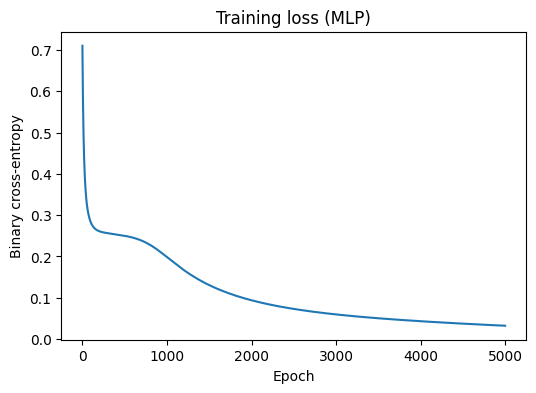

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(loss_history_mlp)
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.title("Training loss (MLP)")
plt.show()

### Valutazione su training e test set

In [ ]:
def accuracy_mlp(X, y, params):
    y_pred, _ = forward_mlp(X, params)
    y_labels = (y_pred >= 0.5).astype(int)
    return np.mean(y_labels.flatten() == y)

acc_train = accuracy_mlp(X_train, y_train, params)
acc_test = accuracy_mlp(X_test, y_test, params)

print(f"Train accuracy: {acc_train:.3f}")
print(f"Test accuracy: {acc_test:.3f}")

Train accuracy: 1.000
Test accuracy: 0.992


### Decision boundary della MLP

Ora disegniamo la **frontiera di decisione** della rete neurale.

Confrontala mentalmente con:
- la forma dei dati
- la frontiera del classificatore lineare

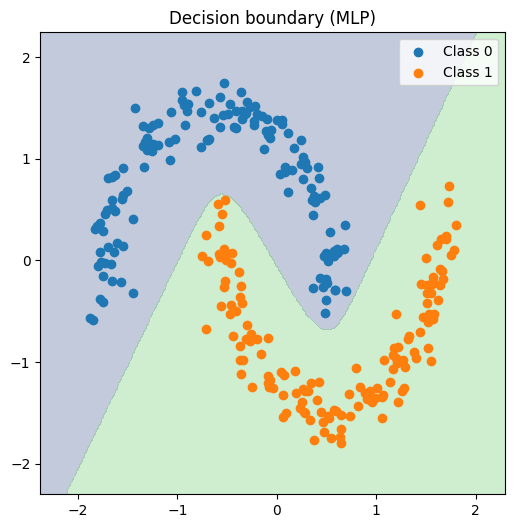

In [ ]:
def plot_decision_boundary_mlp(params, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    preds, _ = forward_mlp(grid, params)
    preds = preds.reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, preds >= 0.5, alpha=0.3)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class 0")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class 1")
    plt.legend()
    plt.title("Decision boundary (MLP)")
    plt.show()

plot_decision_boundary_mlp(params, X_train, y_train)

## 6️⃣bis Mini-batch training per la MLP

Finora abbiamo aggiornato i parametri una volta per epoca usando **tutto** il training set.  
Ora ripetiamo l’addestramento usando **mini-batch training**: in ogni epoca dividiamo i dati in piccoli batch e facciamo un aggiornamento dei pesi per ciascun batch.

---

### Idea

Dato un batch di dimensione \(B\), calcoliamo forward, loss e gradienti solo su quel batch e aggiorniamo:

$$
W \leftarrow W - \eta \nabla_W E_{\text{batch}}
$$

Ripetendo questo passaggio per tutti i batch dell’epoca.

---

### Cosa faremo

1. Mescolare (shuffle) i dati ad ogni epoca
2. Suddividerli in mini-batch
3. Eseguire più update dei pesi per epoca
4. Visualizzare loss, accuracy e decision boundary come prima

In [ ]:
def train_mlp_minibatch(X, y, params, learning_rate=0.01, n_epochs=2000, batch_size=32, seed=42):
    """
    Training della MLP con mini-batch SGD.
    - shuffle ad ogni epoca
    - update per ciascun batch
    """
    rng = np.random.default_rng(seed)
    N = X.shape[0]
    loss_history_mb = []

    for epoch in range(n_epochs):
        # shuffle
        # rng è inizializzato una sola volta: quindi lo shuffle cambia ad ogni epoca
        # ma resta riproducibile grazie al seed iniziale
        idx = rng.permutation(N)
        Xs = X[idx]
        ys = y[idx]

        # mini-batch loop
        epoch_losses = []
        for start in range(0, N, batch_size):
            end = start + batch_size
            Xb = Xs[start:end]
            yb = ys[start:end]

            # forward
            y_pred, cache = forward_mlp(Xb, params)

            # loss
            loss = binary_cross_entropy(y_pred, yb)
            epoch_losses.append(loss)

            # backward
            grads = backward_mlp(cache, yb, params)

            # update
            params["W1"] -= learning_rate * grads["dW1"]
            params["b1"] -= learning_rate * grads["db1"]
            params["W2"] -= learning_rate * grads["dW2"]
            params["b2"] -= learning_rate * grads["db2"]

        # log: loss media dei batch nell'epoca
        loss_history_mb.append(float(np.mean(epoch_losses)))

        if epoch % 200 == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss_history_mb[-1]:.4f}")

    return loss_history_mb

In [ ]:
# Addestramento MLP con mini-batch

H = 8
params_mb = init_mlp(n_in=2, n_hidden=H, seed=1)

loss_history_mb = train_mlp_minibatch(
    X_train, y_train,
    params_mb,
    learning_rate=0.01,
    n_epochs=3000,
    batch_size=16,
    seed=42
)

Epoch    0 | Loss: 0.6890
Epoch  200 | Loss: 0.2632
Epoch  400 | Loss: 0.2485
Epoch  600 | Loss: 0.1832
Epoch  800 | Loss: 0.1367
Epoch 1000 | Loss: 0.1078
Epoch 1200 | Loss: 0.0865
Epoch 1400 | Loss: 0.0736
Epoch 1600 | Loss: 0.0633
Epoch 1800 | Loss: 0.0550
Epoch 2000 | Loss: 0.0514
Epoch 2200 | Loss: 0.0428
Epoch 2400 | Loss: 0.0398
Epoch 2600 | Loss: 0.0349
Epoch 2800 | Loss: 0.0314


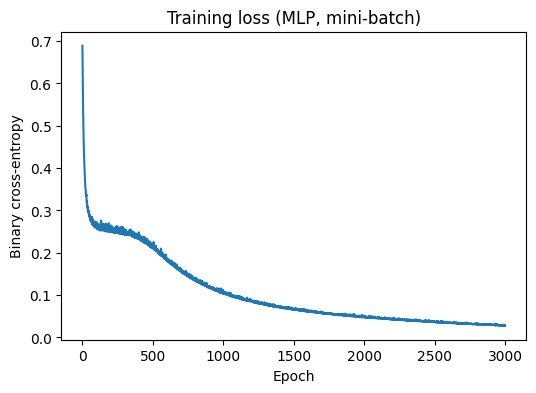

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(loss_history_mb)
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.title("Training loss (MLP, mini-batch)")
plt.show()

In [ ]:
acc_train_mb = accuracy_mlp(X_train, y_train, params_mb)
acc_test_mb  = accuracy_mlp(X_test, y_test, params_mb)

print(f"Train accuracy: {acc_train_mb:.3f}")
print(f"Test accuracy: {acc_test_mb:.3f}")

Train accuracy: 1.000
Test accuracy: 0.992


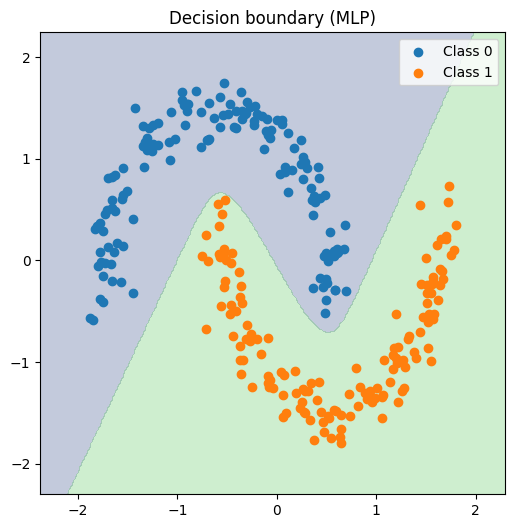

In [ ]:
plot_decision_boundary_mlp(params_mb, X_train, y_train)

## 7️⃣ Confronto finale: lineare vs MLP

Ora possiamo tirare le conclusioni.

### Classificatore lineare
- frontiera: **retta**
- capacità limitata
- non riesce a separare i dati

### MLP con hidden layer
- frontiera **non lineare**
- apprende una trasformazione dei dati
- separa correttamente le due classi

---

## Messaggio chiave del laboratorio

> Una rete neurale non è “magica”.  
> È una sequenza di trasformazioni lineari + non lineari,  
> addestrare con la chain rule (backpropagation).

---


## 8️⃣ Implementazione della MLP in PyTorch

Ora implementiamo **la stessa rete neurale** vista prima, ma usando PyTorch.

La rete è identica:
- input: 2
- hidden layer: H neuroni
- output: 1 neurone (classificazione binaria)

La differenza è che:
- **non scriviamo più la backprop a mano**
- PyTorch calcola automaticamente i gradienti con `autograd`

Useremo una loss numericamente stabile:
- `BCEWithLogitsLoss`, che combina **sigmoid + binary cross-entropy**

In [ ]:
# Import principali di PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

### Conversione dei dati

PyTorch lavora con **tensor**, non con array NumPy.
Convertiamo quindi i dati di training e test.

In [ ]:
# Conversione da NumPy a torch.Tensor
# Le label vengono messe in colonna (N,1) come prima
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

### Dataset e DataLoader

Il DataLoader:
- divide i dati in mini-batch
- mescola i dati ad ogni epoca (shuffle)

In [ ]:
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

### Definizione del modello

Costruiamo la rete:
2 → H → 1

- `Linear(2, H)` = layer nascosto
- `Tanh()` = attivazione non lineare
- `Linear(H, 1)` = output (logit)

⚠️ Non mettiamo la sigmoid nel modello:
la userà direttamente la loss.

In [ ]:
H = 8

model = nn.Sequential(
    nn.Linear(2, H),   # hidden layer
    nn.Tanh(),         # attivazione
    nn.Linear(H, 1)    # output: logit
)

### Loss e ottimizzatore

- `BCEWithLogitsLoss` = sigmoid + BCE insieme
- `SGD` = gradient descent con mini-batch

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

### Training loop

Per ogni epoca:
1. prendiamo un mini-batch
2. facciamo il forward
3. calcoliamo la loss
4. PyTorch calcola automaticamente i gradienti
5. aggiorniamo i pesi

In [ ]:
n_epochs = 2000
loss_history_torch = []

for epoch in range(n_epochs):
    model.train()
    epoch_losses = []

    for xb, yb in train_loader:

        # IMPORTANTE:
        # In PyTorch i gradienti NON vengono azzerati automaticamente.
        # Ogni chiamata a loss.backward() SOMMA i gradienti a quelli già presenti.
        #
        # Se non azzerassimo i gradienti:
        # - il gradiente di questo batch si sommerebbe a quello del batch precedente
        # - l'aggiornamento dei pesi sarebbe sbagliato
        #
        # Qui vogliamo:
        # - un aggiornamento dei pesi per OGNI mini-batch
        # - quindi azzeriamo i gradienti prima di calcolarli
        optimizer.zero_grad()

        logits = model(xb)             # forward pass (calcolo delle predizioni)
        loss = criterion(logits, yb)   # calcolo della loss sul batch

        # Calcolo automatico dei gradienti (backpropagation)
        loss.backward()

        # Aggiornamento dei pesi usando i gradienti appena calcolati
        optimizer.step()

        epoch_losses.append(loss.item())

    loss_history_torch.append(np.mean(epoch_losses))

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss_history_torch[-1]:.4f}")

Epoch    0 | Loss: 0.6438
Epoch  200 | Loss: 0.2323
Epoch  400 | Loss: 0.0879
Epoch  600 | Loss: 0.0379
Epoch  800 | Loss: 0.0224
Epoch 1000 | Loss: 0.0148
Epoch 1200 | Loss: 0.0112
Epoch 1400 | Loss: 0.0088
Epoch 1600 | Loss: 0.0072
Epoch 1800 | Loss: 0.0063


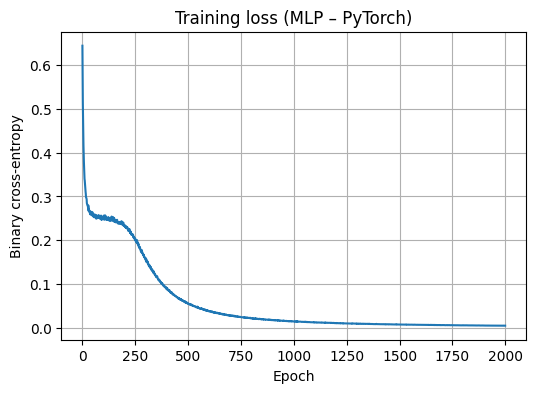

In [ ]:
# Andamento della loss durante il training (PyTorch)

plt.figure(figsize=(6, 4))
plt.plot(loss_history_torch)
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.title("Training loss (MLP – PyTorch)")
plt.grid(True)
plt.show()

In [ ]:
with torch.no_grad():
    probs_train = torch.sigmoid(model(X_train_t))
    preds_train = (probs_train >= 0.5).int()
    acc_train_t = (preds_train == y_train_t.int()).float().mean().item()

    probs_test = torch.sigmoid(model(X_test_t))
    preds_test = (probs_test >= 0.5).int()
    acc_test_t = (preds_test == y_test_t.int()).float().mean().item()

acc_train_t, acc_test_t

(1.0, 1.0)

In [ ]:
# Applichiamo la rete ai primi 10 esempi del test set (PyTorch)

n = 10

with torch.no_grad():
    # Prendiamo i primi n esempi
    X10 = X_test_t[:n]
    y10 = y_test_t[:n]

    # Forward: il modello produce LOGITS (non probabilità)
    logits10 = model(X10)

    # Convertiamo i logits in probabilità con la sigmoid
    probs10 = torch.sigmoid(logits10)

    # Predizione finale (classe 0/1) usando soglia 0.5
    preds10 = (probs10 >= 0.5).int()

# Stampa riga per riga (leggibile)
print("i |   x1     x2   |  logit   |  prob   | pred | true")
print("--+--------------+----------+---------+------+-----")
for i in range(n):
    x1, x2 = X10[i].tolist()
    logit = logits10[i].item()
    prob  = probs10[i].item()
    pred  = preds10[i].item()
    true  = int(y10[i].item())
    print(f"{i:1d} | {x1:+.3f} {x2:+.3f} | {logit:+.3f} | {prob:.3f} |  {pred}   |  {true}")

i |   x1     x2   |  logit   |  prob   | pred | true
--+--------------+----------+---------+------+-----
0 | -1.755 -0.025 | -6.455 | 0.002 |  0   |  0
1 | +0.599 -0.189 | -3.803 | 0.022 |  0   |  0
2 | +0.157 +1.061 | -6.942 | 0.001 |  0   |  0
3 | -0.550 -0.107 | +5.210 | 0.995 |  1   |  1
4 | -0.399 -0.002 | +5.242 | 0.995 |  1   |  1
5 | +0.164 -1.294 | +8.768 | 1.000 |  1   |  1
6 | -1.626 +0.809 | -7.474 | 0.001 |  0   |  0
7 | -1.750 +0.331 | -7.156 | 0.001 |  0   |  0
8 | +0.903 -1.412 | +6.353 | 0.998 |  1   |  1
9 | +1.312 -0.896 | +6.431 | 0.998 |  1   |  1


## 🔍 Perché una MLP NON è un classificatore lineare?

Dopo aver visto che:
- la **logistic regression** fallisce su *two moons*
- una **MLP con un layer nascosto** riesce a separare correttamente i dati

è naturale chiedersi **perché**.

La risposta non è “perché è più potente”, ma è **strutturale**.

---

## 1️⃣ Richiamo: cos’è un classificatore lineare

Un classificatore lineare ha sempre la forma:

$$
f(x) = w^T x + b
$$

La frontiera di decisione è:

$$
w^T x + b = 0
$$

In 2D è una **retta**, in 3D un **piano**, in dimensioni maggiori un **iperpiano**.

Questo vale per:
- logistic regression
- perceptron a singolo layer
- SVM lineare

👉 Se i dati non sono separabili linearmente nello spazio originale, **nessun classificatore lineare può riuscirci**.

---

## 2️⃣ Cosa cambia in una MLP con layer nascosto

La nostra MLP implementa la funzione:

$$
\hat y
=
W^{(2)} \tanh\!\big(W^{(1)} x + b^{(1)}\big) + b^{(2)}
$$

Qui succedono **due cose distinte**:

1. una **trasformazione non lineare** dell’input
2. una **classificazione lineare** sul risultato di tale trasformazione

---

## 3️⃣ È davvero “merito della tanh”?

Sì — **ma non perché è tanh in sé**, bensì perché è **non lineare**.

Se al posto di `tanh` usassimo una funzione lineare:

$$
z^{(1)} = a^{(1)}
$$

otterremmo:

$$
\hat y
=
W^{(2)} (W^{(1)} x + b^{(1)}) + b^{(2)}
=
\tilde W x + \tilde b
$$

cioè **di nuovo un classificatore lineare**.

> 💡 **Più layer lineari in cascata equivalgono a un solo layer lineare.**

👉 Quindi:
- non è il numero di layer
- è la **non-linearità tra i layer** a fare la differenza

---

## 4️⃣ Interpretazione geometrica: la MLP come feature map

Possiamo riscrivere la rete come:

$$
\Phi(x) = \tanh(W^{(1)} x + b^{(1)})
$$

$$
\hat y = W^{(2)} \Phi(x) + b^{(2)}
$$

Questa forma è molto importante:

- $\Phi(x)$ è una **mappa di feature non lineare**
- il classificatore finale è **lineare nello spazio delle feature**

👉 **La MLP è un classificatore lineare nello spazio trasformato $\Phi(x)$**.

---

## 5️⃣ Collegamento con i laboratori precedenti (Φ e SVM)

Nei laboratori precedenti abbiamo visto modelli del tipo:

$$
f(x) = w^T \Phi(x) + b
$$

dove:
- $\Phi(x)$ era **scelta a priori**
- oppure indotta implicitamente tramite un **kernel**

### Confronto concettuale

| Kernel / SVM | MLP |
|-------------|-----|
| $\Phi(x)$ fissata | $\Phi(x)$ **appresa** |
| scelta manualmente | ottimizzata via backprop |
| spesso infinita | finita e parametrica |

👉 **stessa idea, approccio diverso**.

---

## 6️⃣ Cosa sta imparando davvero una MLP?

La MLP non impara solo una frontiera di decisione.

Impara:
$$
\boxed{
\text{una rappresentazione interna } \Phi(x)
}
$$

tale che:
- i dati diventano (quasi) **linearmente separabili**
- un classificatore lineare finale è sufficiente

---

## 7️⃣ Perché *two moons* ora funziona

Nel nostro esperimento:
- nello spazio originale → non separabile
- nello spazio $\Phi(x)$ → separabile

La tanh (o ReLU) **piega lo spazio**, creando nuove feature
che “srotolano” le lune.

---

## 8️⃣ Messaggio chiave del laboratorio

> **Una MLP non è magica:  
> è un classificatore lineare nello spazio giusto.  
> La differenza è che lo spazio giusto lo impara dai dati.**

oppure, in collegamento diretto con gli altri lab:

> **Nei kernel scegliamo $\Phi$.  
> Nelle reti neurali la impariamo.**

## 🔚 Chiusura: Kernel SVM (lezione precedente) vs MLP (questo lab)

Nella lezione precedente abbiamo visto un modo “classico” per gestire dati **non linearmente separabili**: le **SVM con kernel**.  
In questo laboratorio, invece, abbiamo ottenuto una separazione non lineare usando una **MLP** (rete neurale con un layer nascosto).

Qui sotto confrontiamo le due idee in modo semplice e onesto.

---

### 1) Come ottengono una decision boundary non lineare?

#### ✅ Kernel SVM
Una SVM lineare decide con un iperpiano:

$$
f(x)=w^T x + b
$$

Con i kernel, la stessa idea viene applicata **in uno spazio trasformato**:

$$
f(x)=\sum_{i \in SV}\alpha_i t_i K(x_i,x) + b
$$

- la non-linearità entra tramite il **kernel** $K(x_i,x)$  
- la soluzione dipende solo da alcuni punti: i **support vectors (SV)**

Esempi di kernel già visti:
- Polinomiale: $K(x,y)=(x^T y + c)^p$
- RBF/Gaussiano: $K(x,y)=\exp(-\gamma \|x-y\|^2)$

---

#### ✅ MLP
La MLP ottiene non-linearità perché *compone*:

- trasformazioni lineari (pesi + bias)
- **attivazioni non lineari** (tanh, ReLU, ...)

Per la nostra rete:

$$
z^{(1)} = \tanh(XW^{(1)} + b^{(1)})
$$
$$
\hat{y} = \sigma(z^{(1)}W^{(2)} + b^{(2)})
$$

Qui la non-linearità entra tramite $\tanh(\cdot)$ (o ReLU, ecc.).

---

### 2) Cosa “si impara” davvero?

- **Kernel SVM**: non impara feature esplicite, ma “similitudini” tra punti tramite $K$.  
  La decisione è una combinazione di somiglianze con i support vector.

- **MLP**: impara una trasformazione interna (feature) nel layer nascosto $z^{(1)}$.  
  In un certo senso, impara una rappresentazione in cui il problema diventa più separabile.

---

### 3) Pro e contro (in pratica)

#### Kernel SVM
✅ spesso molto efficace su dataset piccoli/medi  
✅ pochi punti “contano” (SV) → interpretazione geometrica forte  
⚠️ con tanti dati $n$ grandi può diventare costosa (kernel matrix)  
⚠️ scelta di $C$, $\gamma$, grado polinomiale… può richiedere tuning

#### MLP
✅ scala bene con tanti dati e feature  
✅ può imparare rappresentazioni complesse (deep)  
⚠️ ottimizzazione non convessa → risultati dipendono da init, lr, architettura  
⚠️ più iperparametri (layer, H, lr, batch size, ecc.)

---

### 4) Messaggio finale (per collegare i due lab)

Kernel SVM e MLP sono due modi diversi di ottenere **non-linearità**:

- **Kernel SVM**: “rendo lineare il problema cambiando lo spazio” (tramite $K$)  
- **MLP**: “imparo lo spazio giusto” (tramite layer + attivazioni + backprop)

Entrambe possono funzionare molto bene su *two moons*:  
la differenza è **come** arrivano a una frontiera non lineare.

---


## 🔎 Alcune considerazioni finali (oltre il laboratorio)

Nel laboratorio abbiamo costruito e addestrato una MLP funzionante, concentrandoci sui **meccanismi fondamentali**  
(forward, loss, backpropagation, update dei pesi).

Ci sono però alcuni aspetti **non trattati in dettaglio**, che è importante conoscere per avere una visione più completa
di come funzionano davvero le reti neurali in pratica.

Questa sezione non introduce nuovo codice, ma serve a **mettere in prospettiva** ciò che abbiamo visto.

---

## 1️⃣ Scelta della dimensione del layer nascosto (H)

Nel laboratorio abbiamo usato un numero fisso di neuroni nascosti (ad esempio `H = 8`).

In generale:

- **H troppo piccolo**
  - la rete ha capacità insufficiente
  - la decision boundary resta troppo semplice
  - il modello *underfitta* (bias alto)

- **H troppo grande**
  - la rete ha molta flessibilità
  - può adattarsi anche al rumore
  - rischio di *overfitting* (varianza alta)

👉 Non esiste un valore “giusto” in assoluto:  
la dimensione del layer nascosto è un **iperparametro** da scegliere in base a:
- complessità dei dati
- quantità di esempi
- regolarizzazione usata

> 💡 In questo laboratorio *two moons* è semplice, quindi bastano pochi neuroni.

---

## 2️⃣ Loss vs Accuracy: perché ottimizziamo la loss?

Durante l’addestramento abbiamo monitorato la **loss**, non l’accuracy.

Perché?

- la **loss** è:
  - continua
  - differenziabile
  - adatta all’ottimizzazione con gradient descent

- l’**accuracy**:
  - è discreta (0/1)
  - non è differenziabile
  - non fornisce un segnale di gradiente utile

👉 Possibili situazioni:
- la loss diminuisce ma l’accuracy resta uguale
- piccoli miglioramenti di probabilità non cambiano ancora la classe predetta

> 💡 Ottimizziamo la loss per **imparare meglio**,  
> valutiamo l’accuracy per **misurare le prestazioni**.

---

## 3️⃣ Effetto del mini-batch training

Nel mini-batch training:

- ogni aggiornamento dei pesi usa **solo una parte dei dati**
- il gradiente è una **stima rumorosa** del gradiente vero

Questo comporta:

- curve di loss più irregolari
- maggiore esplorazione dello spazio dei parametri
- spesso **migliore generalizzazione** rispetto al batch completo

👉 Rumore ≠ errore  
Il rumore del mini-batch può aiutare a:
- uscire da minimi locali poco utili
- evitare soluzioni troppo “rigide”

---

## 4️⃣ Dipendenza dall’inizializzazione

Le reti neurali vengono ottimizzate su funzioni di costo **non convesse**.

Questo significa che:
- il punto di partenza (inizializzazione dei pesi) conta
- inizializzazioni diverse possono portare a soluzioni diverse
- due run identici possono dare risultati leggermente diversi

Nel laboratorio abbiamo:
- fissato un `seed`
- usato una inizializzazione di tipo Xavier

👉 Questo rende gli esperimenti:
- riproducibili
- più stabili

Ma **in generale**, l’inizializzazione è parte del design del modello.

---

## 5️⃣ Saturazione delle funzioni di attivazione

Funzioni come `sigmoid` e `tanh`:

- saturano per valori grandi (positivi o negativi)
- producono gradienti molto piccoli
- possono rallentare l’apprendimento (vanishing gradients)

Nel nostro caso:
- la rete è poco profonda
- i valori sono ben normalizzati
- il problema è limitato

👉 In reti più profonde, queste scelte diventano **critiche**  
(e motivano l’uso di ReLU e varianti).

---

## 6️⃣ Perché PyTorch “sembra più semplice”?

Nel passaggio a PyTorch:

- **la matematica è la stessa**
- cambia solo *chi* calcola i gradienti

Con PyTorch:
- `autograd` applica automaticamente la chain rule
- il codice è più corto
- si riducono gli errori implementativi

👉 Ma capire la versione *from scratch* è fondamentale per:
- sapere cosa sta succedendo davvero
- interpretare errori di training
- scegliere architetture e iperparametri in modo consapevole

